In [49]:

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import r2_score, mean_squared_log_error

In [50]:
stock_df = pd.read_csv('/content/FINAL_FROM_DF.csv')

In [51]:
stock_df

,SYMBOL,SERIES,OPEN,HIGH,LOW,CLOSE,LAST,PREVCLOSE,TOTTRDQTY,TOTTRDVAL,TIMESTAMP,TOTALTRADES,ISIN
0,20MICRONS,EQ,37.80,37.80,36.15,36.85,37.40,37.05,27130,994657.90,2017-06-28,202,INE144J01027
1,3IINFOTECH,EQ,4.10,4.85,4.00,4.55,4.65,4.05,20157058,92148517.65,2017-06-28,7353,INE748C01020
2,3MINDIA,EQ,13425.15,13469.55,12920.00,13266.70,13300.00,13460.55,2290,30304923.35,2017-06-28,748,INE470A01017
3,63MOONS,EQ,61.00,61.90,60.35,61.00,61.10,60.65,27701,1689421.00,2017-06-28,437,INE111B01023
4,8KMILES,EQ,546.10,548.00,535.00,537.45,535.20,547.45,79722,43208620.05,2017-06-28,1866,INE650K01021
...,...,...,...,...,...,...,...,...,...,...,...,...,...
846399,ZOTA,SM,221.00,221.00,214.00,217.00,217.00,220.00,14000,3041550.00,2017-12-29,14,INE358U01012
846400,ZUARI,EQ,562.00,562.00,549.55,550.80,552.00,556.80,105184,58163061.60,2017-12-29,2218,INE840M01016
846401,ZUARIGLOB,EQ,255.50,258.40,252.50,253.25,253.00,254.10,90067,22968100.60,2017-12-29,2001,INE217A01012
846402,ZYDUSWELL,EQ,1038.00,1068.00,1033.00,1043.20,1035.00,1023.10,28601,29938840.10,2017-12-29,1401,INE768C01010


In [52]:
company_df = stock_df[(stock_df['SYMBOL'] == 'ICICIBANK') & (stock_df['SERIES'] == 'EQ')]

In [53]:
company_df

,SYMBOL,SERIES,OPEN,HIGH,LOW,CLOSE,LAST,PREVCLOSE,TOTTRDQTY,TOTTRDVAL,TIMESTAMP,TOTALTRADES,ISIN
616,ICICIBANK,EQ,288.75,293.30,288.75,290.35,289.95,287.90,17157094,4.992441e+09,2017-06-28,94651,INE090A01021
2392,ICICIBANK,EQ,313.10,315.35,311.75,313.20,313.00,317.00,13929413,4.370816e+09,2017-11-28,86488,INE090A01021
4184,ICICIBANK,EQ,278.95,280.10,275.70,276.35,276.70,278.85,16527127,4.578699e+09,2017-02-28,98978,INE090A01021
5911,ICICIBANK,EQ,273.50,279.40,272.90,278.50,277.90,274.15,8515909,2.359974e+09,2017-04-28,69228,INE090A01021
7665,ICICIBANK,EQ,279.70,279.70,274.00,275.05,275.20,280.60,11048388,3.038922e+09,2017-03-20,101834,INE090A01021
...,...,...,...,...,...,...,...,...,...,...,...,...,...
838562,ICICIBANK,EQ,255.20,261.20,252.80,257.65,257.25,254.10,22853993,5.883213e+09,2016-06-08,225541,INE090A01021
840198,ICICIBANK,EQ,222.80,224.85,220.50,221.35,221.05,221.65,12250507,2.721565e+09,2016-03-15,87315,INE090A01021
841816,ICICIBANK,EQ,220.55,223.80,219.55,221.25,221.50,220.30,9078974,2.012991e+09,2016-04-08,60882,INE090A01021
843469,ICICIBANK,EQ,275.80,275.85,269.90,271.25,271.15,275.50,16343247,4.458892e+09,2016-09-23,84233,INE090A01021


In [54]:
# Filter relevant columns and sort by date
company_df = company_df[[ 'TIMESTAMP', 'OPEN', 'HIGH', 'LOW', 'CLOSE','PREVCLOSE']]
company_df['TIMESTAMP'] = pd.to_datetime(company_df['TIMESTAMP'])
company_df = company_df.sort_values(by='TIMESTAMP')

<ipython-input-54-2f0d3f665f84>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_df['TIMESTAMP'] = pd.to_datetime(company_df['TIMESTAMP'])


In [55]:
# Separate features and target
features = company_df[['OPEN', 'HIGH', 'LOW', 'CLOSE','PREVCLOSE']].values

# Split the data into training and test sets (80-20 split)
train_size = int(len(features) * 0.8)
train_data, test_data = features[:train_size], features[train_size:]

In [56]:
# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

In [57]:
# Prepare the data for LSTM
def create_sequences(data, time_steps=60):
    X = []
    y = []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i, :])  # Use all features as input
         # 'CLOSE' column is the target variable # This line now accesses the correct 'CLOSE' column
        y.append(data[i, 3])
    return np.array(X), np.array(y)

# Create sequences for LSTM model
X_train, y_train = create_sequences(train_data)
X_test, y_test = create_sequences(test_data)

In [58]:
# Create Timeseries Generators for training and testing
sequence_length = 16
batch_size = 32

train_generator = TimeseriesGenerator(train_scaled, train_scaled, length=sequence_length, batch_size=batch_size)
test_generator = TimeseriesGenerator(test_scaled, test_scaled, length=sequence_length, batch_size=batch_size)

In [69]:
# # 3. Create a Stacked LSTM Model
# model = Sequential()

# model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, 1)))
# model.add(Dropout(0.2))
# model.add(LSTM(units=50, return_sequences=False))
# model.add(Dropout(0.2))

# model.add(Dense(1))

# model.compile(optimizer='adam', loss='mse')

In [60]:
# 3. Create a Stacked LSTM Model
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, train_scaled.shape[1])))  # Use train_scaled.shape[1] for num_features
model.add(Dropout(0.2))

# Second LSTM layer
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

In [61]:
# Train the model
history = model.fit(train_generator, epochs=10, validation_data=test_generator)

Epoch 1/10
 5/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.2394

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 0.1701 - val_loss: 0.0291
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0211 - val_loss: 0.0317
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0206 - val_loss: 0.0072
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0129 - val_loss: 0.0107
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0136 - val_loss: 0.0088
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0105 - val_loss: 0.0073
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0099 - val_loss: 0.0068
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0106 - val_loss: 0.0097
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0098 - val_loss: 0.0065
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0086 - val_loss: 0.0067


In [62]:
# 4. Predict the Test Data and Plot the Output
test_predictions = model.predict(test_generator)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step


In [63]:
# Inverse transform the predictions and actual values
# Reshape test_predictions to have the same number of features as the original data
test_predictions = test_predictions.reshape(-1, 1)  # Reshape to (n_samples, 1)
test_predictions = scaler.inverse_transform(np.repeat(test_predictions, test_scaled.shape[1], axis=1))[:, 0]  #only take the first column


actual_test_values = scaler.inverse_transform(test_scaled[sequence_length:])[:,0]  #only take the first column

In [65]:
# Calculate R² (R-squared) and RMSLE
r2 = r2_score(actual_test_values, test_predictions)
print(f"R² score: {r2}")

# Calculate RMSLE
rmsle = np.sqrt(mean_squared_log_error(actual_test_values, test_predictions))
print(f"RMSE: {rmsle}")

R² score: 0.6193692263506221
RMSE: 0.03609367763629701


In [66]:
# Predict the Train Data
train_predictions = model.predict(train_generator)

# Reshape train_predictions to have the same number of features as the original data
train_predictions = train_predictions.reshape(-1, 1)  # Reshape to (n_samples, 1)
# Repeat the predictions for each feature to match the original shape
train_predictions = np.repeat(train_predictions, train_scaled.shape[1], axis=1)

# Inverse transform the training predictions and actual values
train_predictions = scaler.inverse_transform(train_predictions)  # Now inverse transform
actual_train_values = scaler.inverse_transform(train_scaled[sequence_length:])

# Extract the 'CLOSE' price column for R² and RMSLE calculations
train_predictions_close = train_predictions[:, 3]  # Extract 'CLOSE' price column
actual_train_values_close = actual_train_values[:, 3]  # Extract 'CLOSE' price column

# Calculate R² and RMSLE for the training set
train_r2 = r2_score(actual_train_values_close, train_predictions_close)
train_rmsle = np.sqrt(mean_squared_log_error(actual_train_values_close, train_predictions_close))

print(f"Training R² score: {train_r2}")
print(f"Training RMSLE: {train_rmsle}")

# Predict the Test Data
test_predictions = model.predict(test_generator)

# Reshape test_predictions to have the same number of features as

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Training R² score: 0.8635851842803186
Training RMSLE: 0.04347890150765772
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [71]:
# Predict the Test Data
test_predictions = model.predict(test_generator)

# Reshape test_predictions to have the same number of features as the original data
test_predictions = test_predictions.reshape(-1, 1)  # Reshape to (n_samples, 1)
# Repeat the predictions for each feature to match the original shape
test_predictions = np.repeat(test_predictions, test_scaled.shape[1], axis=1)

# Inverse transform the test predictions
test_predictions = scaler.inverse_transform(test_predictions)[:,0]  # Inverse and select 'CLOSE'

# Get actual test values for 'CLOSE'
actual_test_values = scaler.inverse_transform(test_scaled[sequence_length:])[:,0]

# Calculate R² and RMSLE for the test set
test_r2 = r2_score(actual_test_values, test_predictions)
test_rmsle = np.sqrt(mean_squared_log_error(actual_test_values, test_predictions))

print(f"Testing R² score: {test_r2}")
print(f"Testing RMSLE: {test_rmsle}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Testing R² score: 0.6193692263506221
Testing RMSLE: 0.03609367763629701


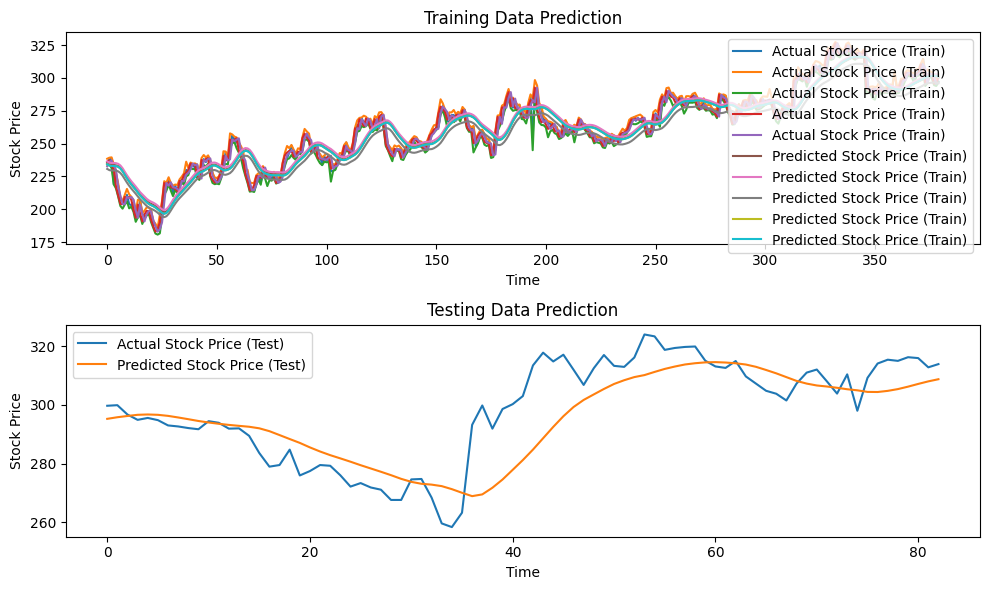

In [68]:
# Plot the predictions vs. actual values for both train and test sets
plt.figure(figsize=(10, 6))

# Plot training data
plt.subplot(2, 1, 1)
plt.plot(actual_train_values, label="Actual Stock Price (Train)")
plt.plot(train_predictions, label="Predicted Stock Price (Train)")
plt.title('Training Data Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()

# Plot testing data
plt.subplot(2, 1, 2)
plt.plot(actual_test_values, label="Actual Stock Price (Test)")
plt.plot(test_predictions, label="Predicted Stock Price (Test)")
plt.title('Testing Data Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()

plt.tight_layout()
plt.show()